In [3]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 93.5 kB/s eta 0:00:18
    --------------------------------------- 0.0/1.7 MB 93.5 kB/s eta 0:00:18
    --------------------------------------- 0.0/1.7 MB 93.5 kB/s eta 0:00:18
    --------------------------------------- 0.0/1.7 MB 93.5 kB/s eta 0:00:18
    --------------------------------------- 0.0/1.7 MB 93.5 kB

In [5]:
from PIL import Image
path1=r'C:\Users\91984\Desktop\my_projects\.ipynb_checkpoints\dataset\dress_images\1.jpg'
path2=r'C:\Users\91984\Desktop\my_projects\.ipynb_checkpoints\dataset\dress_sketch\1.jpg'
img1=Image.open(path1)
img2=Image.open(path2)   

image_new=Image.new('RGB',(img1.width+img2.width ,img1.height))
image_new.paste(img1,(0,0))
image_new.paste(img2,(img1.width,0))
# image_new.paste(img2,(img1.height,0))
# image_new.paste(img2,(img1.width,img1.height))
image_new.save('mergedimage2.png')



In [69]:
from PIL import Image
import os

# Base directory path
base_path_images = r'C:\Users\91984\Desktop\my_projects\.ipynb_checkpoints\dataset\dress_images'
base_path_sketch = r'C:\Users\91984\Desktop\my_projects\.ipynb_checkpoints\dataset\dress_sketch'

# Output directory path
output_path = r'C:\Users\91984\Desktop\my_projects\.ipynb_checkpoints\dataset\test_images'

# Number of images to merge
num_images = 100  # Change this to the desired number

# Iterate over the range of images
for i in range(1, num_images + 1):
    # Construct file paths for images
    image_path = os.path.join(base_path_images, f'{i}.jpg')
    sketch_path = os.path.join(base_path_sketch, f'{i}.jpg')

    # Create a list to store opened images
    images = [Image.open(image_path), Image.open(sketch_path)]

    # Calculate the total width and height for the new image
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    # Create a new image with the calculated dimensions
    image_new = Image.new('RGB', (total_width, max_height))

    # Paste each image onto the new image
    current_width = 0
    for img in images:
        image_new.paste(img, (current_width, 0))
        current_width += img.width

    # Save the merged image with a distinct name
    output_file_path = os.path.join(output_path, f'test_image_{i}.png')
    image_new.save(output_file_path)


In [4]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [ ]:
!pip install tensorflow-gpu==2.3.0
!pip install keras==2.4.3
!pip install wget

In [ ]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices ,enable=True)

In [5]:
BATCH_SIZE = 1
IMAGE_SIZE = 256

In [6]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [9]:
print(os.getcwd())

C:\Users\91984\Desktop\my_projects\pix2pix


In [7]:
path ="my_projects\pix2pix\dataset"
x, y = load(os.path.join(path, "merged_images\merged_image_1.png"))
print(x.shape, y.shape)

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: my_projects\pix2pix\dataset\merged_images\merged_image_1.png : The system cannot find the path specified.
; No such process [Op:ReadFile]

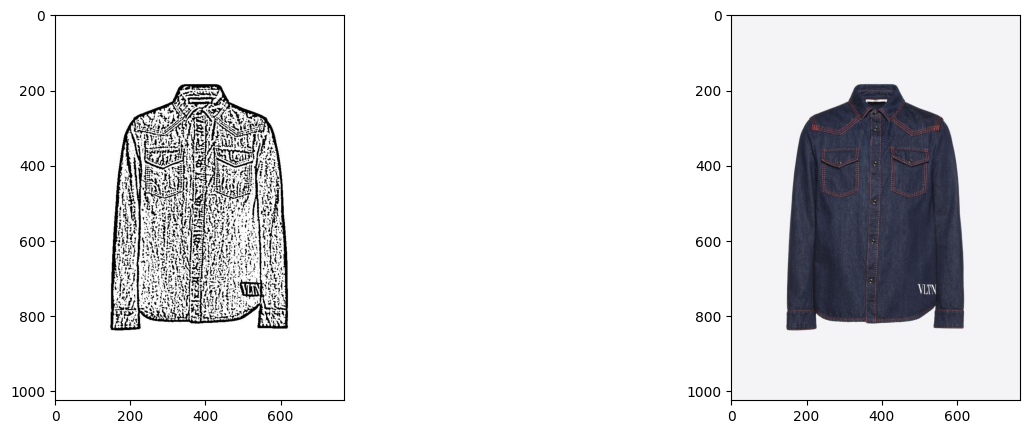

In [16]:
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x/255.0)
axes[1].imshow(y/255.0)

In [17]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [18]:
def resize(input_image, real_image):
    input_image = tf.image.resize(input_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [19]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, IMAGE_SIZE, IMAGE_SIZE, 3])
    return cropped_image[0], cropped_image[1]

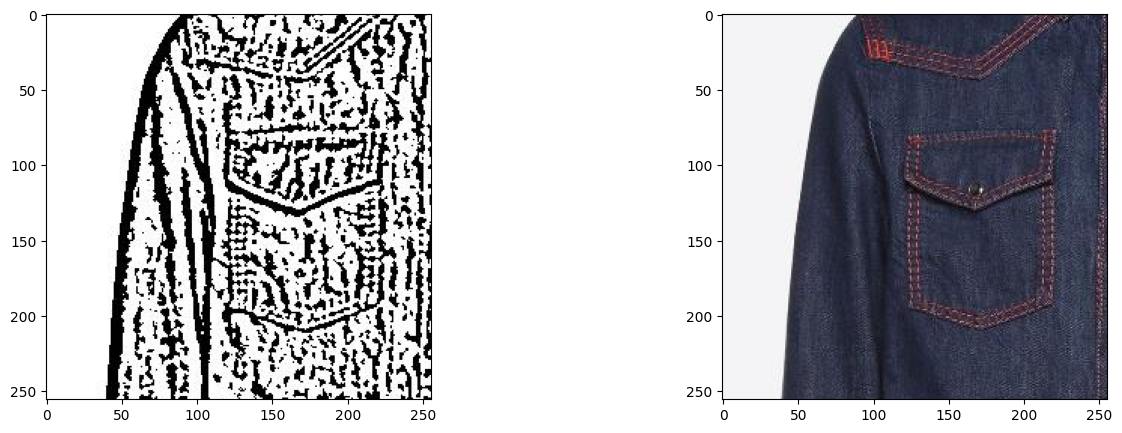

In [20]:
x_aug, y_aug = random_crop(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_aug/255.0)
axes[1].imshow(y_aug/255.0)

In [21]:
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

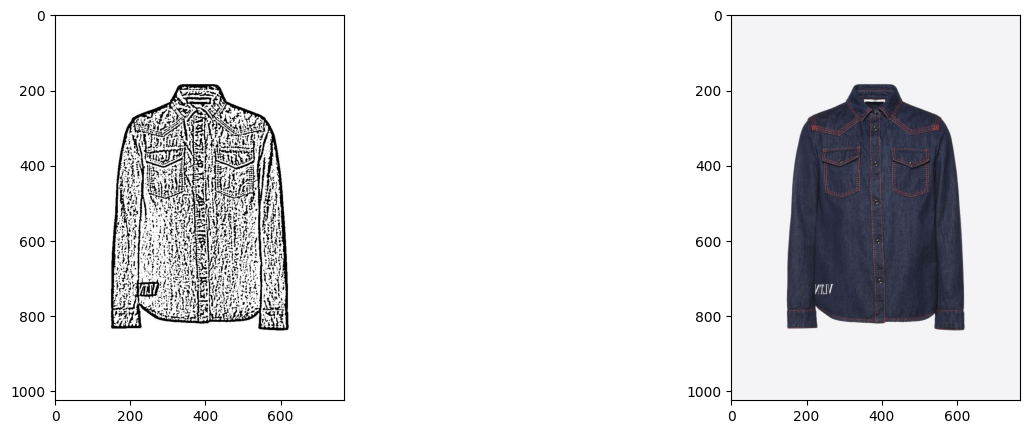

In [22]:
x_jit, y_jit = random_jitter(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_jit/255.0)
axes[1].imshow(y_jit/255.0)

In [23]:
def load_train_images(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image,real_image

In [24]:
def load_test_image(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [25]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path,"merged_images" + "merged_image_/*.png")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [26]:
test_dataset = tf.data.Dataset.list_files(path ,"test_images"+ "test_image_/*.png")
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [27]:
def downsample(filters, size, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)



(1, 512, 384, 3)


In [28]:
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 1024, 768, 3)


In [29]:
def generator():
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    
    
    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    return Model(inputs = inputs, outputs = x)

In [30]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64, 64, 128)          131584    ['sequential_2[0][0]']        
                                                                                                  
 sequential_4 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_3[0][0]']        
                                                                                              

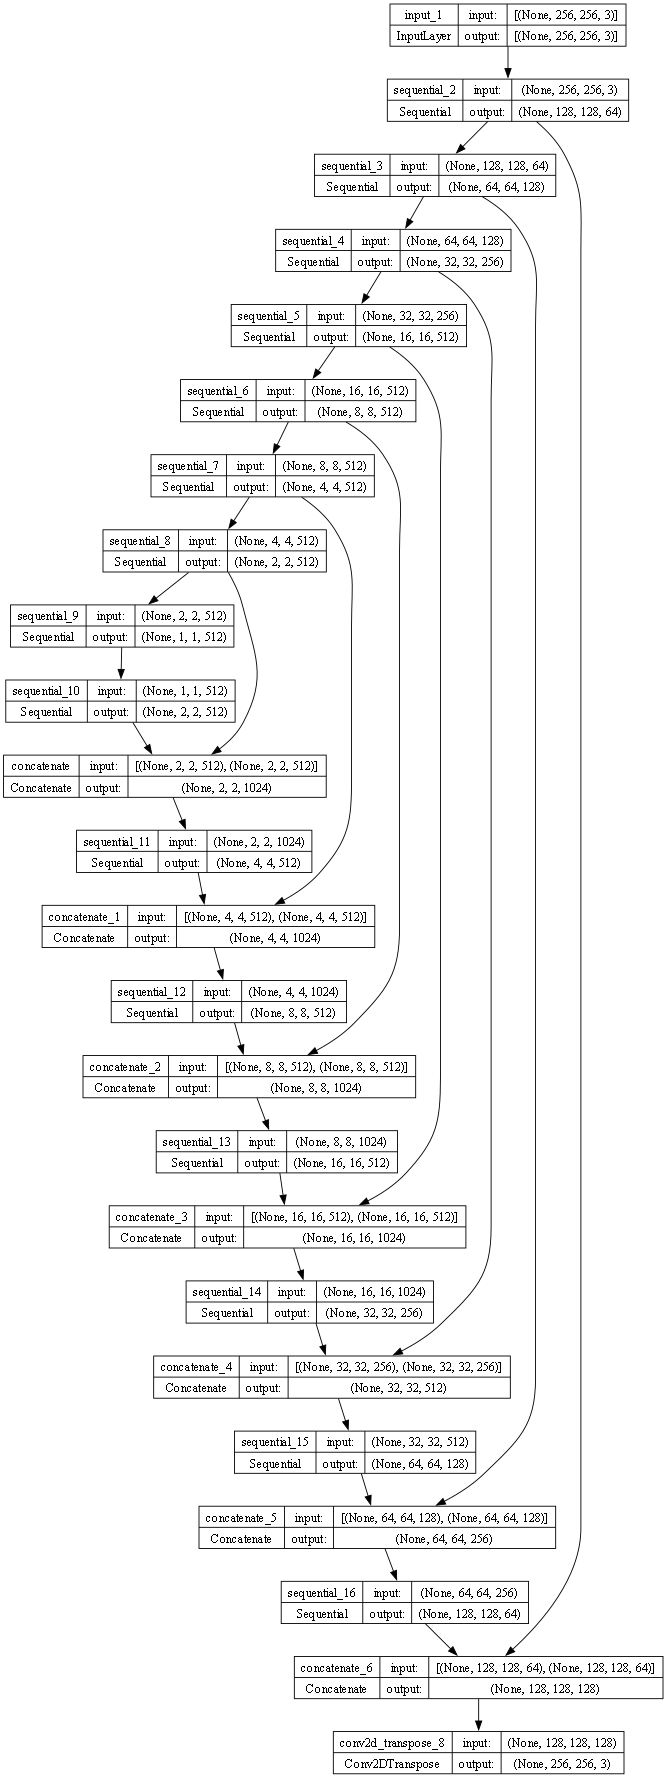

In [31]:
plot_model(gen, show_shapes=True, dpi = 64)

In [23]:
LAMBDA = 100

In [32]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [33]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [34]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

In [36]:
disc = discriminator()
disc.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_8 (Concatenate  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 )                                                                   'target_image[0][0]']        
                                                                                                  
 sequential_20 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_8[0][0]'] 

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [29]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [37]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (15,15))
    display_list= [test_input[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicton Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()

In [38]:
if os.path.exists("output"):
    os.mkdir("output")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'output'

In [39]:
epochs = 100

In [40]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [41]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))

In [42]:
import keras
keras.backend.clear_session()


In [43]:
fit(train_dataset, epochs, test_dataset)

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: C:\Users\91984\Desktop\my_projects\pix2pix\dataset : Access is denied.
; Input/output error
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 